Import Relevant Libraries

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial
from jax.experimental import stax
from jax.experimental import optimizers
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from jax.lib import xla_bridge

Define the System Analytically

In [ ]:
# For mass 1, let us call displacements and accelerations z1 and g1. 
# Repeat the same for mass 2 if we wanted another mass in the system.

def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  z1, z2 = q
  z1_dot, z2_dot = q_dot 

  # Define the kinetic energies.
  T1 = 0.5 * m1 * (z1_dot**2)
  T2 = 0 # We leave out mass 2 as we're not currently modelling it. 
  T = T1 + T2
  
  # Define the potential energies.
  y1 = 0.5*l1*(z1**2) + m1*g*z1
  y2 = 0 # We leave out mass 2 as we're not currently modelling it. 
  V = y1 + y2

  return T - V

def f_analytical(state, t=0, m1=1, m2=0, k1=1, k2=0, g=9.8):
  z1, z2, z1_dot, z2_dot = state
  g1 =  (m1/m1)*g - (k1/m1)*z1 - (1/m1)*z1**3 + (np.random.random()/100)
  z2_dot = 0
  g2 = 0
  return jnp.stack([z1_dot, z2_dot, g1, g2])

Define Relevant Functions

In [ ]:
# Define the output of the Lagrangian network (the acceleration) to be used 
# within the loss function.
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

# Use the odeint to solve the Lagrangian modelled system.
def solve_lagrangian(lagrangian, initial_state, **kwargs):
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

# Use the odeint to solve the system analytically for generating training data. 
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Ensure that all inputs are normalised to only vary between -1 and 1. 
# def normalise(state):
#   return jnp.concatenate([state[:2], state[2:]])
def normalise(state):
  return jnp.concatenate([(state[:2] + 1) % (2) - 1, state[2:]])

# Define 4th order Runge-Kutta method for integration of losses. 
def rk4_step(f, x, t, h):
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

Generate Training Data

In [ ]:
time_step = 0.01
N = 10 # End time of total time-series
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

x0_train = np.array([1.0, 0, 0, 0], dtype=np.float32)
t_train = np.arange(N, dtype=np.float32) 
x_train = jax.device_get(solve_analytical(x0_train, t_train)) 
xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) 
y_train = jax.device_get(analytical_step(x_train)) 

# The test dataset is simply a continuation of the training dataset. 
x0_test = np.array([1.0, 0, 0, 0], dtype=np.float32)
t_test = np.arange(N, 2*N,dtype=np.float32) 
x_test = jax.device_get(solve_analytical(x0_test, t_test))
xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) 
y_test = jax.device_get(analytical_step(x_test)) 

# Normalise datasets. 
x_train = jax.device_put(jax.vmap(normalise)(x_train))
y_train = jax.device_put(y_train)
x_test = jax.device_put(jax.vmap(normalise)(x_test))
y_test = jax.device_put(y_test)

Initialise Neural Network

In [ ]:
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalise(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# Now we define the loss function of the model. In our case it is the Mean 
# Squared Error between the predicted and the observed accelerations. 
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# Set up the Neural Network. 
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(32),
    stax.Softplus,
    stax.Dense(32),
    stax.Softplus,
    stax.Dense(1),
)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

# @jax.jit
# def update_timestep(i, opt_state, batch):
#   params = get_params(opt_state)
#   return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

Train the Neural Network

In [ ]:
%%time
# Initialise the parametes in the neural network to be random. 
rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# Define the training process. 
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# Define the training optimiser.
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

# Perform training process. 
for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))*1000
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))*1000
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=69249.718750, test_loss=69244.890625
iteration=1000, train_loss=5.036716, test_loss=5.038467
iteration=2000, train_loss=1.735142, test_loss=1.736660
iteration=3000, train_loss=0.455272, test_loss=0.453567
iteration=4000, train_loss=0.147435, test_loss=0.148584
iteration=5000, train_loss=9.180703, test_loss=9.033940
iteration=6000, train_loss=0.066244, test_loss=0.064491
iteration=7000, train_loss=0.051404, test_loss=0.052248
iteration=8000, train_loss=0.044515, test_loss=0.046786
iteration=9000, train_loss=0.057983, test_loss=0.052235
iteration=10000, train_loss=0.632424, test_loss=0.584741
iteration=11000, train_loss=2.643320, test_loss=2.736564
iteration=12000, train_loss=0.026077, test_loss=0.028070
iteration=13000, train_loss=0.021634, test_loss=0.023203
iteration=14000, train_loss=0.018004, test_loss=0.019273
iteration=15000, train_loss=0.014926, test_loss=0.016918
iteration=16000, train_loss=0.021158, test_loss=0.028610
iteration=17000, train_loss=0.010122

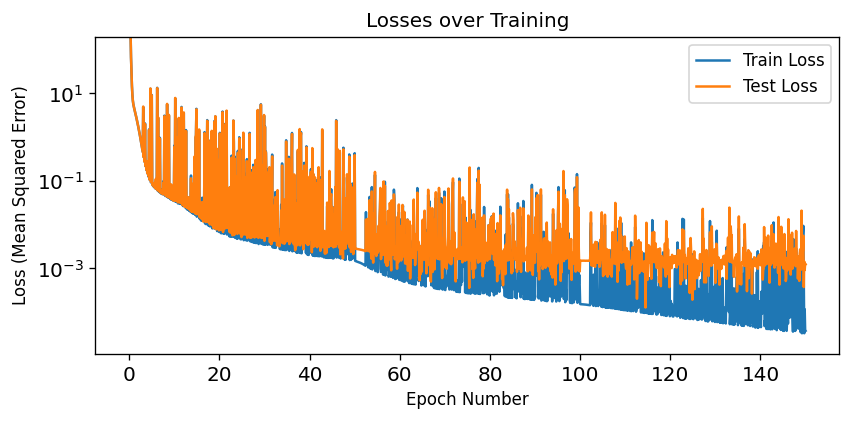

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.rc('xtick', labelsize= 12)
plt.rc('ytick', labelsize= 12)

epochs = np.linspace(0, ((batch_size/(N/time_step))*num_batches), (num_batches + 1))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over Training')
plt.xlabel("Epoch Number")
plt.ylabel("Loss (Mean Squared Error)")
plt.legend()
plt.show()

Make Predictions Using Trained Model

In [ ]:
# choose an initial state
x1 = np.array([1.0, 0.0, 0, 0], dtype=np.float32)
time = np.linspace(0, 150, num=2500)
x1_analytical = jax.device_get(solve_analytical(x1, time))
%time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=time))

CPU times: user 3.39 s, sys: 11 ms, total: 3.41 s
Wall time: 3.38 s


Normalised Root Mean Square Error: 
0.33539


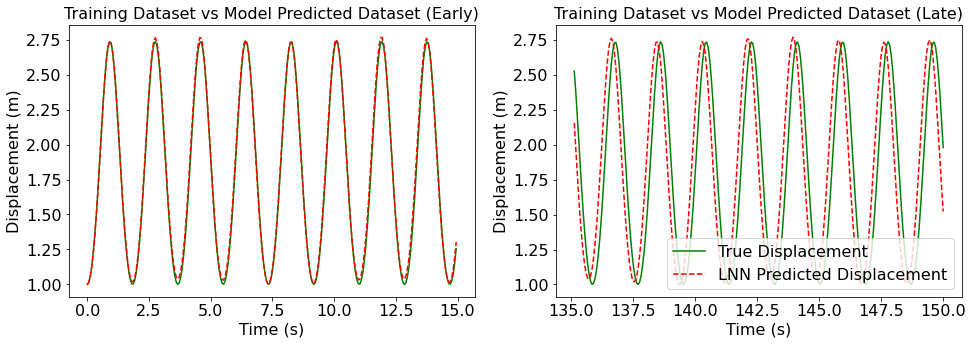

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(16,5))
plt.rc('xtick', labelsize= 16)
plt.rc('ytick', labelsize= 16)

time_1 = time[time<15]
x1_analytical_1 = x1_analytical[time<15]
x1_model_1 = x1_model[time<15]
axis[0].set_title("Training Dataset vs Model Predicted Dataset (Early)", fontsize=16)
axis[0].plot(time_1[time_1<15], x1_analytical_1[:, 0], 'g-', label=r'True Displacement')
axis[0].plot(time_1, x1_model_1[:, 0], 'r--', label=r'LNN Predicted Displacement')
axis[0].set_xlabel("Time (s)", fontsize=16)
axis[0].set_ylabel("Displacement (m)", fontsize=16)

n = max(time) - max(time_1) # Display predicted behaviour for later on. 
time_2 = time[time>n]               
x1_analytical_2 = x1_analytical[time>n]
x1_model_2 = x1_model[time>n]
axis[1].set_title("Training Dataset vs Model Predicted Dataset (Late)", fontsize=16)
axis[1].plot(time_2, x1_analytical_2[:, 0], 'g-', label=r'True Displacement')
axis[1].plot(time_2, x1_model_2[:, 0], 'r--', label=r'LNN Predicted Displacement')
axis[1].set_xlabel("Time (s)", fontsize=16)
axis[1].set_ylabel("Displacement (m)", fontsize=16)
axis[1].legend(fontsize=16, loc='lower right')

E2_error = 0
analytical = (x1_analytical[:, 0] - np.mean(x1_analytical[:, 0]))/np.std(x1_analytical[:, 0])
model = (x1_model[:, 0] - np.mean(x1_model[:, 0]))/np.std(x1_model[:, 0])
for i in range(0, len(time)):
  E2_error = E2_error + (abs((analytical[i] - model[i])**2))
E2_error = (E2_error / len(time))**0.5
print("Normalised Root Mean Square Error: ")
print('{0:.5f}'.format(E2_error))

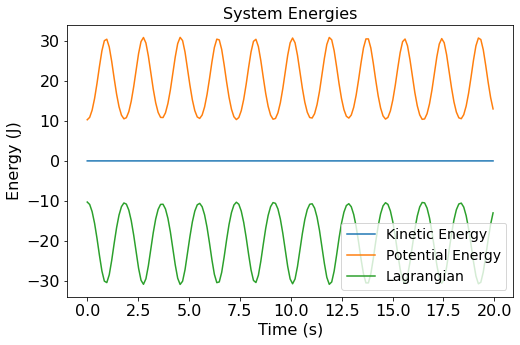

In [ ]:
m = 1
k = 1
g = 9.81
KE_analytical = 0.5*m*(x1_analytical[:,1])**2
PE_analytical = 0.5*k*(x1_analytical[:,0])**2 - m*g*(x1_analytical[:,0])
L_analytical = KE_analytical - PE_analytical

KE_model = 0.5*m*(x1_model[:,1])**2
PE_model = 0.5*k*(x1_model[:,0])**2 + m*g*(x1_model[:,0])
L_model = KE_model - PE_model

plt.figure(figsize=(8, 5))
plt.rc('xtick', labelsize= 16)
plt.rc('ytick', labelsize= 16)

plt.plot(time[time<20], KE_model[time<20], label='Kinetic Energy')
plt.plot(time[time<20], PE_model[time<20], label='Potential Energy')
plt.plot(time[time<20], L_model[time<20], label='Lagrangian')
plt.title('System Energies', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Energy (J)', fontsize=16)
plt.legend(prop={'size': 14}, loc='lower right')
plt.rc('axes', labelsize='LARGE') 

In [ ]:
# # choose an initial state
# x1 = np.array([1.0, 0, 0, 0], dtype=np.float32)
# time = np.linspace(0, 100, num=2500)
# x1_analytical = jax.device_get(solve_analytical(x1, time))
# %time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=time))

# figure, axis = plt.subplots(2, 1, figsize=(10,15))

# time_1 = time[time<15]
# x1_analytical_1 = x1_analytical[time<15]
# x1_model_1 = x1_model[time<15]
# axis[0].set_title("Analytic vs LNN - Early (Training Dataset)", fontsize=16)
# axis[0].plot(time_1, x1_analytical_1[:, 0], 'g-', label=r'Exact Displacement')
# axis[0].plot(time_1, x1_model_1[:, 0], 'r--', label=r'LNN Predicted Displacement')
# axis[0].set_xlabel("Time (s)", fontsize=16)
# axis[0].set_ylabel("Displacement (m)", fontsize=16)
# axis[0].legend(fontsize=14, loc='lower right')
# plt.rc('xtick', labelsize='LARGE')

# n = max(time) - max(time_1) # Display predicted behaviour for later on. 
# time_2 = time[time>n]               
# x1_analytical_2 = x1_analytical[time>n]
# x1_model_2 = x1_model[time>n]
# axis[1].set_title("Analytic vs LNN - Late (Training Dataset)", fontsize=16)
# axis[1].plot(time_2, x1_analytical_2[:, 0], 'g-', label=r'Exact Displacement')
# axis[1].plot(time_2, x1_model_2[:, 0], 'r--', label=r'LNN Predicted Displacement')
# axis[1].set_xlabel("Time (s)", fontsize=16)
# axis[1].set_ylabel("Displacement (m)", fontsize=16)
# axis[1].legend(fontsize=16, loc='lower right')
# plt.rc('xtick', labelsize='LARGE')

# E2_error = 0
# analytical = x1_analytical[:, 0]
# model = x1_model[:, 0] 
# for i in range(0, len(time)):
#   E2_error = E2_error + (abs((analytical[i] - model[i])**2))
# E2_error = (E2_error / len(time))**0.5
# print("Root Mean Square Error: ")
# print('{0:.5f}'.format(E2_error))

In [ ]:
# # choose an initial state
# x1 = np.array([1.5, 0, 0, 0], dtype=np.float32)
# time = np.linspace(0, 100, num=2500)
# x1_analytical = jax.device_get(solve_analytical(x1, time))
# %time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=time))

# figure, axis = plt.subplots(2, 1, figsize=(10,15))

# time_1 = time[time<15]
# x1_analytical_1 = x1_analytical[time<15]
# x1_model_1 = x1_model[time<15]
# axis[0].set_title("Analytic vs LNN - Early (Testing Dataset)", fontsize=16)
# axis[0].plot(time_1, x1_analytical_1[:, 0], 'g-', label=r'Exact Displacement')
# axis[0].plot(time_1, x1_model_1[:, 0], 'r--', label=r'LNN Predicted Displacement')
# axis[0].set_xlabel("Time (s)", fontsize=16)
# axis[0].set_ylabel("Displacement (m)", fontsize=16)
# axis[0].legend(fontsize=14, loc='lower right')
# plt.rc('xtick', labelsize='LARGE')

# n = max(time) - max(time_1) # Display predicted behaviour for later on. 
# time_2 = time[time>n]               
# x1_analytical_2 = x1_analytical[time>n]
# x1_model_2 = x1_model[time>n]
# axis[1].set_title("Analytic vs LNN - Late (Testing Dataset)", fontsize=16)
# axis[1].plot(time_2, x1_analytical_2[:, 0], 'g-', label=r'Exact Displacement')
# axis[1].plot(time_2, x1_model_2[:, 0], 'r--', label=r'LNN Predicted Displacement')
# axis[1].set_xlabel("Time (s)", fontsize=16)
# axis[1].set_ylabel("Displacement (m)", fontsize=16)
# axis[1].legend(fontsize=16, loc='lower right')
# plt.rc('xtick', labelsize='LARGE')

# E2_error = 0
# analytical = x1_analytical[:, 0]
# model = x1_model[:, 0] 
# for i in range(0, len(time)):
#   E2_error = E2_error + (abs((analytical[i] - model[i])**2))
# E2_error = (E2_error / len(time))**0.5
# print("Root Mean Square Error: ")
# print('{0:.5f}'.format(E2_error))

In [ ]:
# m = 1
# k = 5
# g = 9.81
# KE_analytical = 0.5*m*(x1_analytical[:,1])**2
# PE_analytical = 0.5*k*(x1_analytical[:,0])**2 + m*g*(x1_analytical[:,0])
# L_analytical = KE_analytical - PE_analytical

# KE_model = 0.5*m*(x1_model[:,1])**2
# PE_model = 0.5*k*(x1_model[:,0])**2 + m*g*(x1_model[:,0])
# L_model = KE_model - PE_model

# figure, axis = plt.subplots(2, 1, figsize=(10,15))

# time_1 = time[time<15]
# x1_analytical_1 = x1_analytical[time<15]
# x1_model_1 = x1_model[time<15]
# axis[0].set_title("Predicted Energies Over Time vs LNN", fontsize=16)
# axis[0].plot(time[time<15], KE_analytical[time<15], 'g-', label=r'Kinetic Energy')
# axis[0].plot(time[time<15], PE_analytical[time<15], 'r-', label=r'Potential Energy')
# axis[0].set_xlabel("Time (s)", fontsize=16)
# axis[0].set_ylabel("Energy (J)", fontsize=16)
# axis[0].legend(fontsize=14, loc='lower right')
# plt.rc('xtick', labelsize='LARGE')

# axis[1].set_title("Predicted Energies Over Time vs LNN", fontsize=16)
# axis[1].plot(time[time<15], KE_model[time<15], 'g-', label=r'Kinetic Energy')
# axis[1].plot(time[time<15], PE_model[time<15], 'r-', label=r'Potential Energy')
# axis[1].set_xlabel("Time (s)", fontsize=16)
# axis[1].set_ylabel("Energy (J)", fontsize=16)
# axis[1].legend(fontsize=14, loc='lower right')
# plt.rc('xtick', labelsize='LARGE')

In [ ]:
# m = 1
# k = 1
# g = 9.81

# plt.plot(time[time<15], KE_model[time<15])
# plt.plot(time[time<15], PE_model[time<15])
# plt.plot(time[time<15], L_model[time<15])
# plt.title('System Energies (Predicted Data)')
# plt.xlabel('Time (s)')
# plt.ylabel('Energy (J)')